# Practica 4, Equipo 9

#Problematica

En esta práctica se aborda una problemática de negocio relacionada con la predicción del abandono de clientes (churn) en una empresa de telecomunicaciones, utilizando técnicas de modelación supervisada y análisis exploratorio de datos.

## 0. Importacion de Modulos

In [1]:
import sys
import matplotlib.pyplot as plt
import re
import numpy as np
import pandas as pd
import unicodedata
from datetime import datetime # pip install xlrd
import seaborn as sns


from sklearn.ensemble import RandomForestClassifier

## 0. Funciones Auxiliares 

In [2]:
def freq_discrete(df, features):
    """
    Calcula y muestra tablas de frecuencias absolutas, relativas y acumuladas para variables categóricas.

    Parámetros
    ----------
    df : pandas.DataFrame
        DataFrame que contiene las variables a analizar.
    features : list of str
        Lista con los nombres de las columnas categóricas a analizar.

    Descripción
    -----------
    Para cada variable en `features`, imprime su nombre y muestra una tabla con:
      - Frecuencia absoluta de cada categoría.
      - Frecuencia relativa (porcentaje) de cada categoría.
      - Frecuencia absoluta acumulada.
      - Frecuencia relativa acumulada.
    Los valores se formatean para mejor visualización.

    Ejemplo
    -------
    freq_discrete(df, ["color", "country"])
    """
    for feature in features:
        print(f"Feature: {feature}")
        abs_series = df[feature].value_counts(dropna=False)
        rel_series = df[feature].value_counts(dropna=False, normalize=True)
        freq = pd.DataFrame({"Absolute frequency": abs_series, "Relative frequency": rel_series})
        freq["Accumulated frequency"] = freq["Absolute frequency"].cumsum()
        freq["Accumulated %"] = freq["Relative frequency"].cumsum()
        freq["Absolute frequency"] = freq["Absolute frequency"].map(lambda x: "{:,.0f}".format(x))
        freq["Relative frequency"] = freq["Relative frequency"].map(lambda x: "{:,.2%}".format(x))
        freq["Accumulated frequency"] = freq["Accumulated frequency"].map(lambda x: "{:,.0f}".format(x))
        freq["Accumulated %"] = freq["Accumulated %"].map(lambda x: "{:,.2%}".format(x))
        display(freq)

## 1. Data Wrangling

### 1.1 Carga de datos

In [3]:
import pandas as pd
import numpy as np
import sys

# Instalamos motores de lectura por si faltan
!{sys.executable} -m pip install xlrd openpyxl

ruta_original = 'data/WA_Fn-UseC_-Telco-Customer-Churn.xls'
ruta_csv = 'data/Telco_Churn.csv'

try:
    # Intento 1: Leer como Excel estándar
    df = pd.read_excel(ruta_original, engine='xlrd')
except:
    # Intento 2: Si el .xls es en realidad un CSV disfrazado
    df = pd.read_csv(ruta_original)

# Guardar como CSV real para evitar problemas futuros
df.to_csv(ruta_csv, index=False)
print(" Archivo cargado y convertido a CSV correctamente.")
df.head()

 Archivo cargado y convertido a CSV correctamente.



[notice] A new release of pip available: 22.3.1 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### 1.2 Limpieza de datos

In [4]:

freq_discrete(df,df.columns)

Feature: customerID


,Absolute frequency,Relative frequency,Accumulated frequency,Accumulated %
customerID,,,,
7590-VHVEG,1,0.01%,1,0.01%
3791-LGQCY,1,0.01%,2,0.03%
6008-NAIXK,1,0.01%,3,0.04%
5956-YHHRX,1,0.01%,4,0.06%
5365-LLFYV,1,0.01%,5,0.07%
...,...,...,...,...
9796-MVYXX,1,0.01%,"7,039",99.94%
2637-FKFSY,1,0.01%,"7,040",99.96%
1552-AAGRX,1,0.01%,"7,041",99.97%


Feature: gender


,Absolute frequency,Relative frequency,Accumulated frequency,Accumulated %
gender,,,,
Male,"3,555",50.48%,"3,555",50.48%
Female,"3,488",49.52%,"7,043",100.00%


Feature: SeniorCitizen


,Absolute frequency,Relative frequency,Accumulated frequency,Accumulated %
SeniorCitizen,,,,
0,"5,901",83.79%,"5,901",83.79%
1,"1,142",16.21%,"7,043",100.00%


Feature: Partner


,Absolute frequency,Relative frequency,Accumulated frequency,Accumulated %
Partner,,,,
No,"3,641",51.70%,"3,641",51.70%
Yes,"3,402",48.30%,"7,043",100.00%


Feature: Dependents


,Absolute frequency,Relative frequency,Accumulated frequency,Accumulated %
Dependents,,,,
No,"4,933",70.04%,"4,933",70.04%
Yes,"2,110",29.96%,"7,043",100.00%


Feature: tenure


,Absolute frequency,Relative frequency,Accumulated frequency,Accumulated %
tenure,,,,
1,613,8.70%,613,8.70%
72,362,5.14%,975,13.84%
2,238,3.38%,"1,213",17.22%
3,200,2.84%,"1,413",20.06%
4,176,2.50%,"1,589",22.56%
...,...,...,...,...
28,57,0.81%,"6,875",97.61%
39,56,0.80%,"6,931",98.41%
44,51,0.72%,"6,982",99.13%


Feature: PhoneService


,Absolute frequency,Relative frequency,Accumulated frequency,Accumulated %
PhoneService,,,,
Yes,"6,361",90.32%,"6,361",90.32%
No,682,9.68%,"7,043",100.00%


Feature: MultipleLines


,Absolute frequency,Relative frequency,Accumulated frequency,Accumulated %
MultipleLines,,,,
No,"3,390",48.13%,"3,390",48.13%
Yes,"2,971",42.18%,"6,361",90.32%
No phone service,682,9.68%,"7,043",100.00%


Feature: InternetService


,Absolute frequency,Relative frequency,Accumulated frequency,Accumulated %
InternetService,,,,
Fiber optic,"3,096",43.96%,"3,096",43.96%
DSL,"2,421",34.37%,"5,517",78.33%
No,"1,526",21.67%,"7,043",100.00%


Feature: OnlineSecurity


,Absolute frequency,Relative frequency,Accumulated frequency,Accumulated %
OnlineSecurity,,,,
No,"3,498",49.67%,"3,498",49.67%
Yes,"2,019",28.67%,"5,517",78.33%
No internet service,"1,526",21.67%,"7,043",100.00%


Feature: OnlineBackup


,Absolute frequency,Relative frequency,Accumulated frequency,Accumulated %
OnlineBackup,,,,
No,"3,088",43.84%,"3,088",43.84%
Yes,"2,429",34.49%,"5,517",78.33%
No internet service,"1,526",21.67%,"7,043",100.00%


Feature: DeviceProtection


,Absolute frequency,Relative frequency,Accumulated frequency,Accumulated %
DeviceProtection,,,,
No,"3,095",43.94%,"3,095",43.94%
Yes,"2,422",34.39%,"5,517",78.33%
No internet service,"1,526",21.67%,"7,043",100.00%


Feature: TechSupport


,Absolute frequency,Relative frequency,Accumulated frequency,Accumulated %
TechSupport,,,,
No,"3,473",49.31%,"3,473",49.31%
Yes,"2,044",29.02%,"5,517",78.33%
No internet service,"1,526",21.67%,"7,043",100.00%


Feature: StreamingTV


,Absolute frequency,Relative frequency,Accumulated frequency,Accumulated %
StreamingTV,,,,
No,"2,810",39.90%,"2,810",39.90%
Yes,"2,707",38.44%,"5,517",78.33%
No internet service,"1,526",21.67%,"7,043",100.00%


Feature: StreamingMovies


,Absolute frequency,Relative frequency,Accumulated frequency,Accumulated %
StreamingMovies,,,,
No,"2,785",39.54%,"2,785",39.54%
Yes,"2,732",38.79%,"5,517",78.33%
No internet service,"1,526",21.67%,"7,043",100.00%


Feature: Contract


,Absolute frequency,Relative frequency,Accumulated frequency,Accumulated %
Contract,,,,
Month-to-month,"3,875",55.02%,"3,875",55.02%
Two year,"1,695",24.07%,"5,570",79.09%
One year,"1,473",20.91%,"7,043",100.00%


Feature: PaperlessBilling


,Absolute frequency,Relative frequency,Accumulated frequency,Accumulated %
PaperlessBilling,,,,
Yes,"4,171",59.22%,"4,171",59.22%
No,"2,872",40.78%,"7,043",100.00%


Feature: PaymentMethod


,Absolute frequency,Relative frequency,Accumulated frequency,Accumulated %
PaymentMethod,,,,
Electronic check,"2,365",33.58%,"2,365",33.58%
Mailed check,"1,612",22.89%,"3,977",56.47%
Bank transfer (automatic),"1,544",21.92%,"5,521",78.39%
Credit card (automatic),"1,522",21.61%,"7,043",100.00%


Feature: MonthlyCharges


,Absolute frequency,Relative frequency,Accumulated frequency,Accumulated %
MonthlyCharges,,,,
20.05,61,0.87%,61,0.87%
19.85,45,0.64%,106,1.51%
19.95,44,0.62%,150,2.13%
19.90,44,0.62%,194,2.75%
20.00,43,0.61%,237,3.37%
...,...,...,...,...
23.65,1,0.01%,"7,039",99.94%
114.70,1,0.01%,"7,040",99.96%
43.65,1,0.01%,"7,041",99.97%


Feature: TotalCharges


,Absolute frequency,Relative frequency,Accumulated frequency,Accumulated %
TotalCharges,,,,
,11,0.16%,11,0.16%
20.2,11,0.16%,22,0.31%
19.75,9,0.13%,31,0.44%
20.05,8,0.11%,39,0.55%
19.9,8,0.11%,47,0.67%
...,...,...,...,...
6849.4,1,0.01%,"7,039",99.94%
692.35,1,0.01%,"7,040",99.96%
130.15,1,0.01%,"7,041",99.97%


Feature: Churn


,Absolute frequency,Relative frequency,Accumulated frequency,Accumulated %
Churn,,,,
No,"5,174",73.46%,"5,174",73.46%
Yes,"1,869",26.54%,"7,043",100.00%


In [5]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [6]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [7]:
# 1. Aseguramos que TotalCharges sea numérico (corrigiendo errores de la imagen)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# 2. Eliminación de nulos (generados por espacios vacíos en TotalCharges)
df.dropna(subset=['TotalCharges'], inplace=True)

# 3. Exportar a CSV para estandarizar el flujo de trabajo del equipo
df.to_csv('data/Telco_Churn_Clean.csv', index=False)
print(" Datos limpios y exportados a 'data/Telco_Churn_Clean.csv'")

 Datos limpios y exportados a 'data/Telco_Churn_Clean.csv'


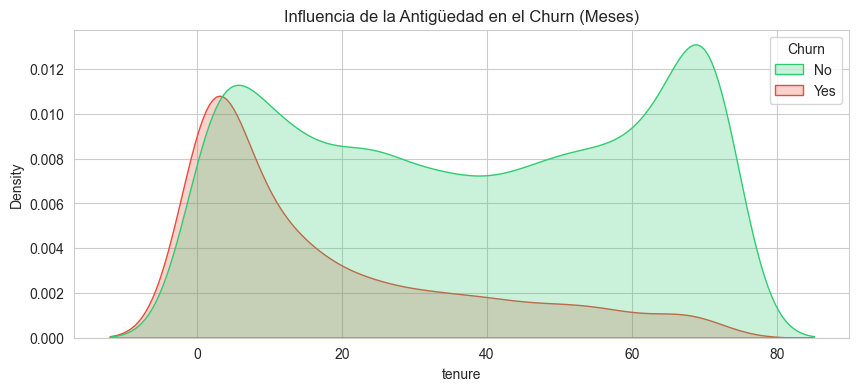

In [8]:
# Configuración estética
sns.set_style("whitegrid")
palette_churn = {"Yes": "#E74C3C", "No": "#2ECC71"}

# --- INSIGHT 1: La antigüedad del cliente (Tenure) frente al abandono
plt.figure(figsize=(10, 4))
sns.kdeplot(data=df, x='tenure', hue='Churn', fill=True, palette=palette_churn)
plt.title('Influencia de la Antigüedad en el Churn (Meses)')
plt.show()

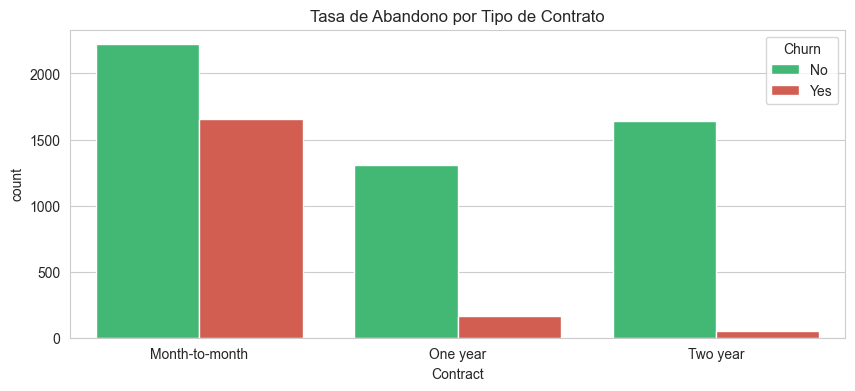

In [9]:
# --- INSIGHT 2: Contratos mes a mes ---
plt.figure(figsize=(10, 4))
contract_order = ['Month-to-month', 'One year', 'Two year']
sns.countplot(data=df, x='Contract', hue='Churn', order=contract_order, palette=palette_churn)
plt.title('Tasa de Abandono por Tipo de Contrato')
plt.show()

C:\Users\casti\AppData\Local\Temp\ipykernel_5416\2577621463.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Churn', y='MonthlyCharges', palette=palette_churn)


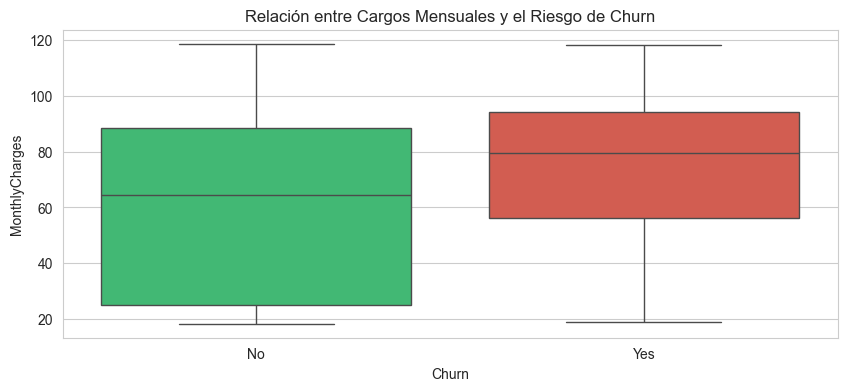

In [10]:
# --- INSIGHT 3: Cargos mensuales altos ---
plt.figure(figsize=(10, 4))
sns.boxplot(data=df, x='Churn', y='MonthlyCharges', palette=palette_churn)
plt.title('Relación entre Cargos Mensuales y el Riesgo de Churn')
plt.show()

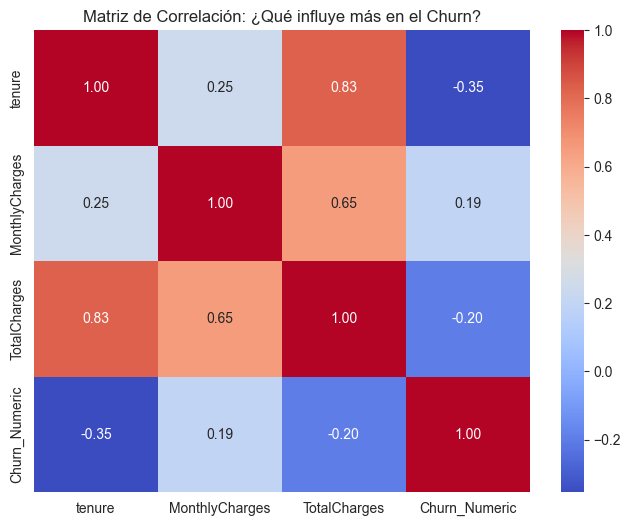

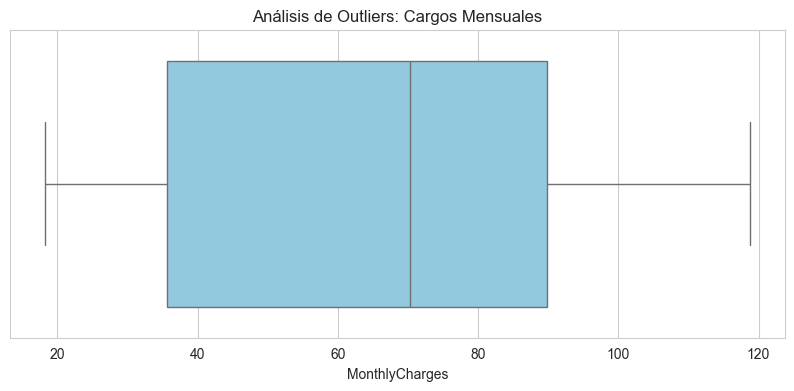

In [11]:
# 1. Preparación para correlación: Convertir Churn a binario (0 y 1)
df_corr = df.copy()
df_corr['Churn_Numeric'] = df_corr['Churn'].map({'Yes': 1, 'No': 0})

# 2. Matriz de Correlación (Solo variables clave)
plt.figure(figsize=(8, 6))
cols_interes = ['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn_Numeric']
sns.heatmap(df_corr[cols_interes].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación: ¿Qué influye más en el Churn?')
plt.show()

# 3. Detección de Outliers en Cargos Mensuales
plt.figure(figsize=(10, 4))
sns.boxplot(x=df['MonthlyCharges'], color='skyblue')
plt.title('Análisis de Outliers: Cargos Mensuales')
plt.show()


💡 Porcentaje de Churn según OnlineSecurity:



,% Churn
OnlineSecurity,
No,41.78%
Yes,14.64%
No internet service,7.43%


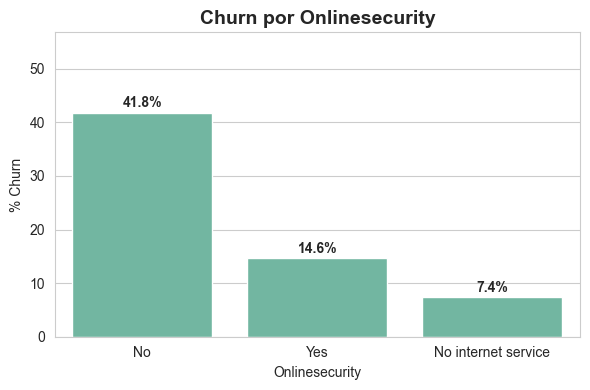


💡 Porcentaje de Churn según OnlineBackup:



,% Churn
OnlineBackup,
No,39.94%
Yes,21.57%
No internet service,7.43%


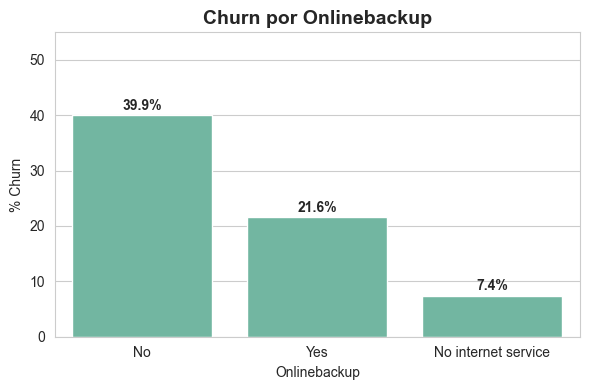


💡 Porcentaje de Churn según DeviceProtection:



,% Churn
DeviceProtection,
No,39.14%
Yes,22.54%
No internet service,7.43%


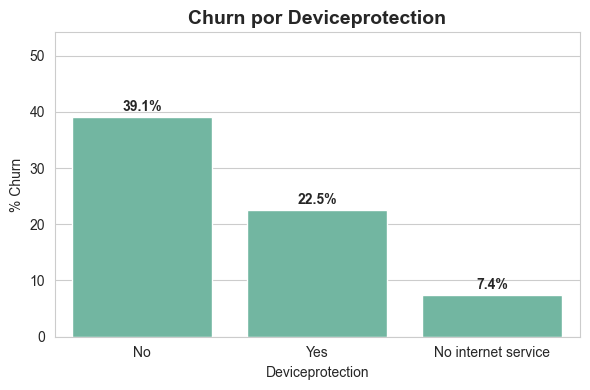


💡 Porcentaje de Churn según TechSupport:



,% Churn
TechSupport,
No,41.65%
Yes,15.20%
No internet service,7.43%


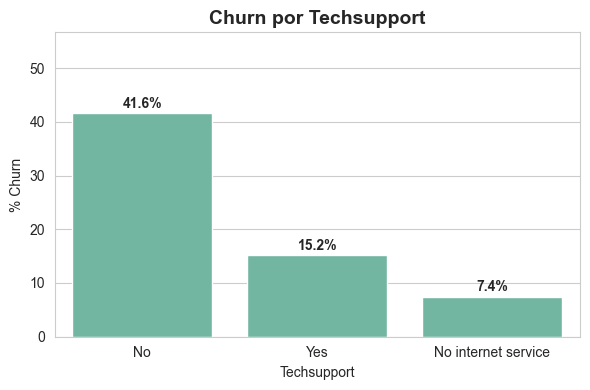


💡 Porcentaje de Churn según StreamingTV:



,% Churn
StreamingTV,
No,33.54%
Yes,30.11%
No internet service,7.43%


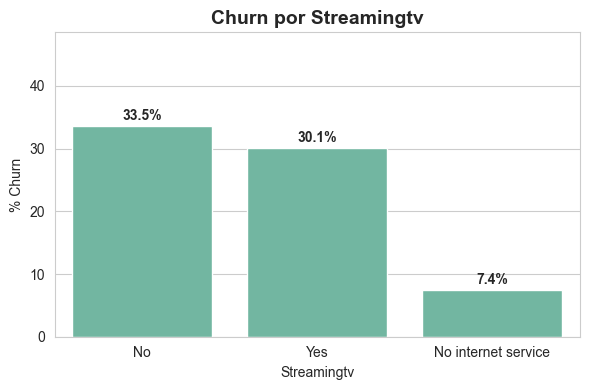


💡 Porcentaje de Churn según StreamingMovies:



,% Churn
StreamingMovies,
No,33.73%
Yes,29.95%
No internet service,7.43%


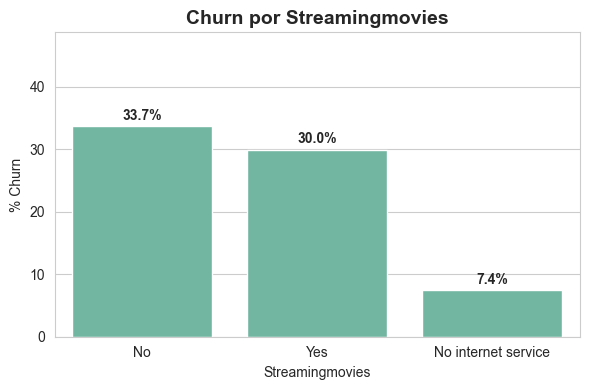

In [12]:
sns.set_style("whitegrid")
sns.set_palette("Set2")

servicios = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies']

for s in servicios:

    churn_pct = df.groupby(s)['Churn'].value_counts(normalize=True).unstack()['Yes']*100
    churn_pct = churn_pct.sort_values(ascending=False)  # Ordenar de mayor a menor churn
    print(f"\n💡 Porcentaje de Churn según {s}:\n")
    display(churn_pct.to_frame(name='% Churn').style.format("{:.2f}%"))


    plt.figure(figsize=(6,4))
    ax = sns.barplot(x=churn_pct.index, y=churn_pct.values)
    
    for i, v in enumerate(churn_pct.values):
        ax.text(i, v + 1, f"{v:.1f}%", ha='center', fontweight='bold')
    
    plt.ylabel('% Churn')
    plt.xlabel(s.replace('_',' ').title())
    plt.title(f'Churn por {s.replace("_"," ").title()}', fontsize=14, fontweight='bold')
    plt.ylim(0, churn_pct.values.max() + 15)
    plt.tight_layout()
    plt.show()

,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Churn
OnlineSecurity_No,1.00,-0.52,-0.63,0.38,-0.52,0.06,0.37,-0.52,0.06,0.47,-0.52,-0.04,0.26,-0.52,0.18,0.27,-0.52,0.17,0.34
OnlineSecurity_No internet service,-0.52,1.00,-0.33,-0.46,1.00,-0.38,-0.47,1.00,-0.38,-0.52,1.00,-0.34,-0.43,1.00,-0.41,-0.42,1.00,-0.42,-0.23
OnlineSecurity_Yes,-0.63,-0.33,1.00,0.00,-0.33,0.28,0.01,-0.33,0.27,-0.05,-0.33,0.35,0.11,-0.33,0.18,0.09,-0.33,0.19,-0.17
OnlineBackup_No,0.38,-0.46,0.00,1.00,-0.46,-0.64,0.36,-0.46,0.03,0.39,-0.46,-0.00,0.32,-0.46,0.07,0.31,-0.46,0.08,0.27
OnlineBackup_No internet service,-0.52,1.00,-0.33,-0.46,1.00,-0.38,-0.47,1.00,-0.38,-0.52,1.00,-0.34,-0.43,1.00,-0.41,-0.42,1.00,-0.42,-0.23
OnlineBackup_Yes,0.06,-0.38,0.28,-0.64,-0.38,1.00,0.03,-0.38,0.30,0.05,-0.38,0.29,0.04,-0.38,0.28,0.05,-0.38,0.27,-0.08
DeviceProtection_No,0.37,-0.47,0.01,0.36,-0.47,0.03,1.00,-0.47,-0.64,0.42,-0.47,-0.04,0.42,-0.47,-0.03,0.43,-0.47,-0.04,0.25
DeviceProtection_No internet service,-0.52,1.00,-0.33,-0.46,1.00,-0.38,-0.47,1.00,-0.38,-0.52,1.00,-0.34,-0.43,1.00,-0.41,-0.42,1.00,-0.42,-0.23
DeviceProtection_Yes,0.06,-0.38,0.27,0.03,-0.38,0.30,-0.64,-0.38,1.00,0.01,-0.38,0.33,-0.07,-0.38,0.39,-0.08,-0.38,0.40,-0.07
TechSupport_No,0.47,-0.52,-0.05,0.39,-0.52,0.05,0.42,-0.52,0.01,1.00,-0.52,-0.63,0.35,-0.52,0.09,0.35,-0.52,0.09,0.34


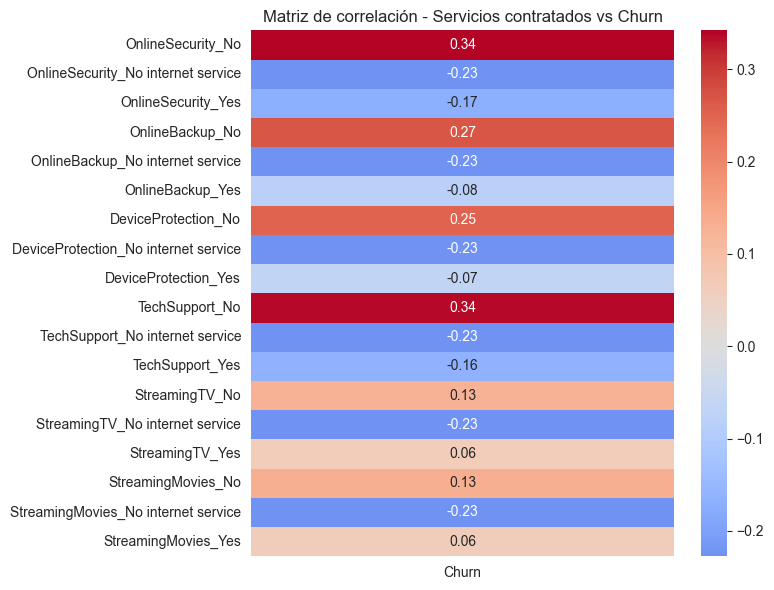

In [13]:
df_services = df[servicios + ['Churn']].copy()

df_encoded = pd.get_dummies(
    df_services,
    columns=servicios,
    drop_first=False
)
df_encoded.head()

df_encoded['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

X = pd.get_dummies(df[servicios], drop_first=False).astype(int)
y = df['Churn'].map({'Yes': 1, 'No': 0})
corr_matrix = pd.concat([X, y], axis=1).corr()
display(corr_matrix.style.format("{:.2f}"))
plt.figure(figsize=(8,6))
sns.heatmap(
    corr_matrix.loc[X.columns, ['Churn']],
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    cbar=True
)
plt.title("Matriz de correlación - Servicios contratados vs Churn")
plt.tight_layout()
plt.show()

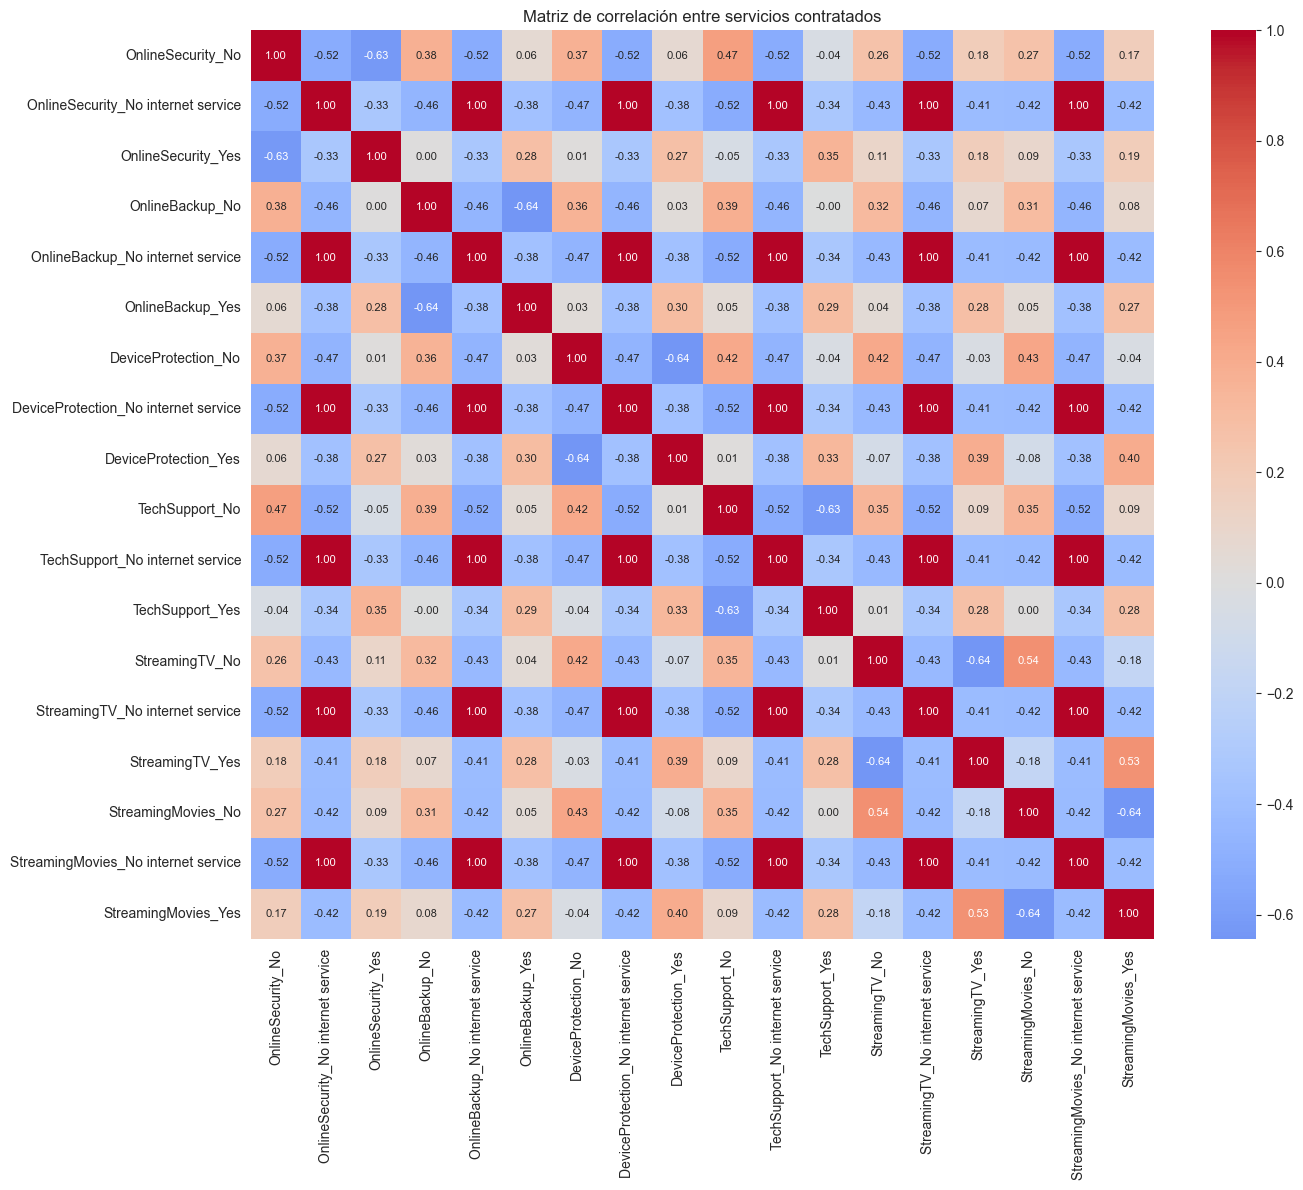

In [14]:
X = pd.get_dummies(df[servicios], drop_first=False).astype(int)

# Matriz de correlación
corr_services = X.corr()

# Heatmap con valores
plt.figure(figsize=(14,12))
sns.heatmap(
    corr_services,
    annot=True,       
    fmt=".2f",           
    cmap="coolwarm",
    center=0,
    cbar=True,
    annot_kws={"size":8}
)

plt.title("Matriz de correlación entre servicios contratados")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [15]:
"""
El análisis de los servicios contratados muestra que los clientes que no tienen activados servicios complementarios, como seguridad en línea, 
soporte técnico, respaldo de datos o servicios de streaming, presentan una mayor probabilidad de abandonar la compañía. 
En particular, los servicios relacionados con la seguridad y el soporte tienen un efecto más fuerte en la retención, mientras que los servicios de entretenimiento ayudan,
pero en menor medida. Esto indica que ofrecer y fomentar la contratación de estos servicios puede ser una estrategia efectiva para reducir el churn y 
mejorar la fidelidad de los clientes.

"""

'\nEl análisis de los servicios contratados muestra que los clientes que no tienen activados servicios complementarios, como seguridad en línea, \nsoporte técnico, respaldo de datos o servicios de streaming, presentan una mayor probabilidad de abandonar la compañía. \nEn particular, los servicios relacionados con la seguridad y el soporte tienen un efecto más fuerte en la retención, mientras que los servicios de entretenimiento ayudan,\npero en menor medida. Esto indica que ofrecer y fomentar la contratación de estos servicios puede ser una estrategia efectiva para reducir el churn y \nmejorar la fidelidad de los clientes.\n\n'

In [16]:
#--- INSIGHT 4: -El método de pago influye en el comportamiento de churn ---

df_pay = df[['PaymentMethod', 'Churn']].copy()

df_pay['Churn'] = df_pay['Churn'].map({'Yes': 1, 'No': 0})

df_encoded = pd.get_dummies(
    df_pay,
    columns=['PaymentMethod'],
    drop_first=False
).astype(int)


distribucion_pago = (
    df_pay
    .groupby('PaymentMethod')['Churn']
    .mean()
    .sort_values(ascending=False) * 100
)

print("Tasa de Churn por método de pago (%):\n")
display(distribucion_pago.to_frame(name='Churn_%'))

Tasa de Churn por método de pago (%):



,Churn_%
PaymentMethod,
Electronic check,45.285412
Mailed check,19.201995
Bank transfer (automatic),16.731518
Credit card (automatic),15.253123


,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn
PaymentMethod_Bank transfer (automatic),1.00,-0.28,-0.38,-0.29,-0.12
PaymentMethod_Credit card (automatic),-0.28,1.00,-0.37,-0.29,-0.13
PaymentMethod_Electronic check,-0.38,-0.37,1.00,-0.39,0.30
PaymentMethod_Mailed check,-0.29,-0.29,-0.39,1.00,-0.09
Churn,-0.12,-0.13,0.30,-0.09,1.00


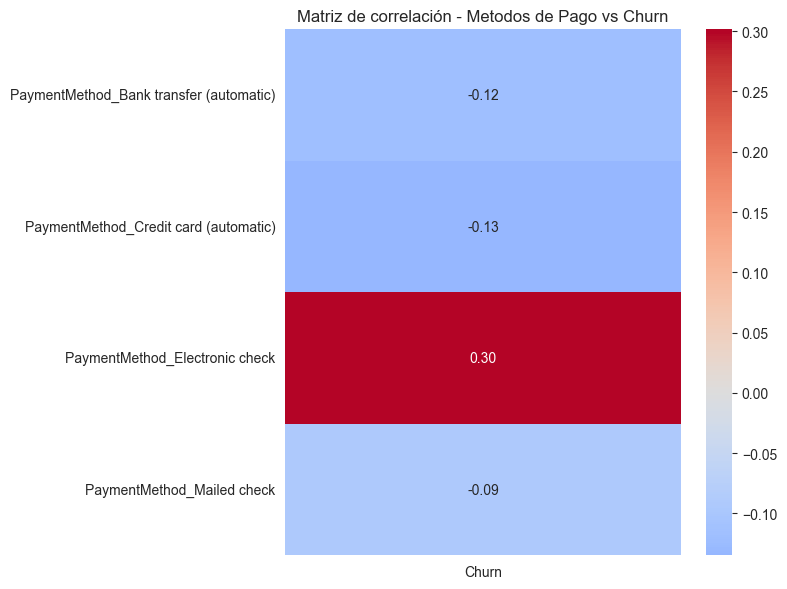

In [17]:

X = df_encoded[['PaymentMethod_Bank transfer (automatic)','PaymentMethod_Credit card (automatic)','PaymentMethod_Electronic check', 'PaymentMethod_Mailed check']]
y = df['Churn'].map({'Yes': 1, 'No': 0})
corr_matrix = pd.concat([X, y], axis=1).corr()
display(corr_matrix.style.format("{:.2f}"))
plt.figure(figsize=(8,6))
sns.heatmap(
    corr_matrix.loc[X.columns, ['Churn']],
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    cbar=True
)
plt.title("Matriz de correlación - Metodos de Pago vs Churn")
plt.tight_layout()
plt.show()

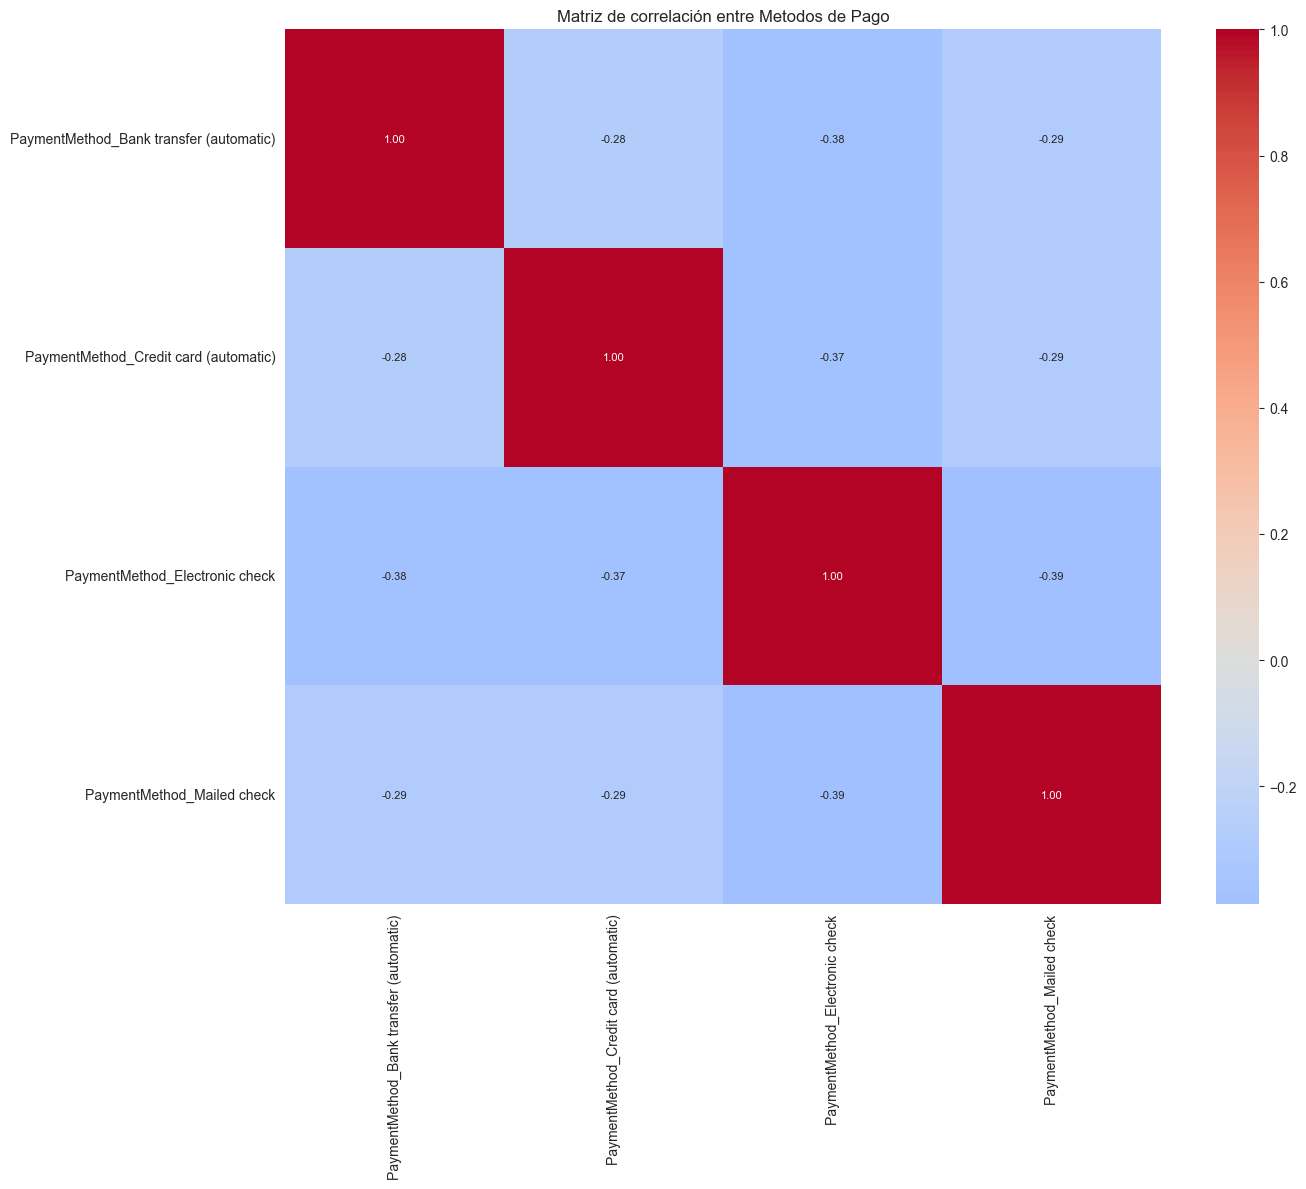

In [18]:
# Matriz de correlación
corr_services = X.corr()

# Heatmap con valores
plt.figure(figsize=(14,12))
sns.heatmap(
    corr_services,
    annot=True,         
    fmt=".2f",         
    cmap="coolwarm",
    center=0,
    cbar=True,
    annot_kws={"size":8} 
)

plt.title("Matriz de correlación entre Metodos de Pago")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [19]:
"""
El análisis evidencia que el método de pago influye en el comportamiento de churn. Los clientes que utilizan Electronic check presentan una mayor probabilidad de abandono, 
mientras que aquellos con pagos automáticos,como transferencia bancaria o tarjeta de crédito, muestran una menor tasa de churn.
Esto sugiere que la automatización del pago está asociada con un mayor compromiso y estabilidad del cliente, 
convirtiendo al método de pago en una variable relevante para la predicción del churn.
"""


'\nEl análisis evidencia que el método de pago influye en el comportamiento de churn. Los clientes que utilizan Electronic check presentan una mayor probabilidad de abandono, \nmientras que aquellos con pagos automáticos,como transferencia bancaria o tarjeta de crédito, muestran una menor tasa de churn.\nEsto sugiere que la automatización del pago está asociada con un mayor compromiso y estabilidad del cliente, \nconvirtiendo al método de pago en una variable relevante para la predicción del churn.\n'

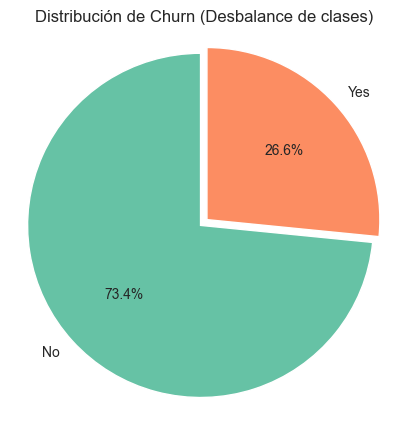

In [20]:
# INSIGHT 6: -El Dataset presenta un desbalance---

churn_counts = df['Churn'].value_counts()


plt.figure(figsize=(5,5))
plt.pie(
    churn_counts,
    labels=churn_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    explode=[0, 0.05]
)

plt.title('Distribución de Churn (Desbalance de clases)')
plt.axis('equal')  # Hace el pastel circular
plt.show()

In [21]:
"""
La distribución de la variable objetivo muestra un desbalance moderado de clases, donde la mayoría de los clientes no abandona, 
Aunque el churn representa una proporción menor, su presencia es significativa
"""


'\nLa distribución de la variable objetivo muestra un desbalance moderado de clases, donde la mayoría de los clientes no abandona, \nAunque el churn representa una proporción menor, su presencia es significativa\n'

### Seleccion de Variables 

C:\Users\casti\AppData\Local\Temp\ipykernel_5416\2473440976.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlations.values, y=correlations.index, palette='viridis')


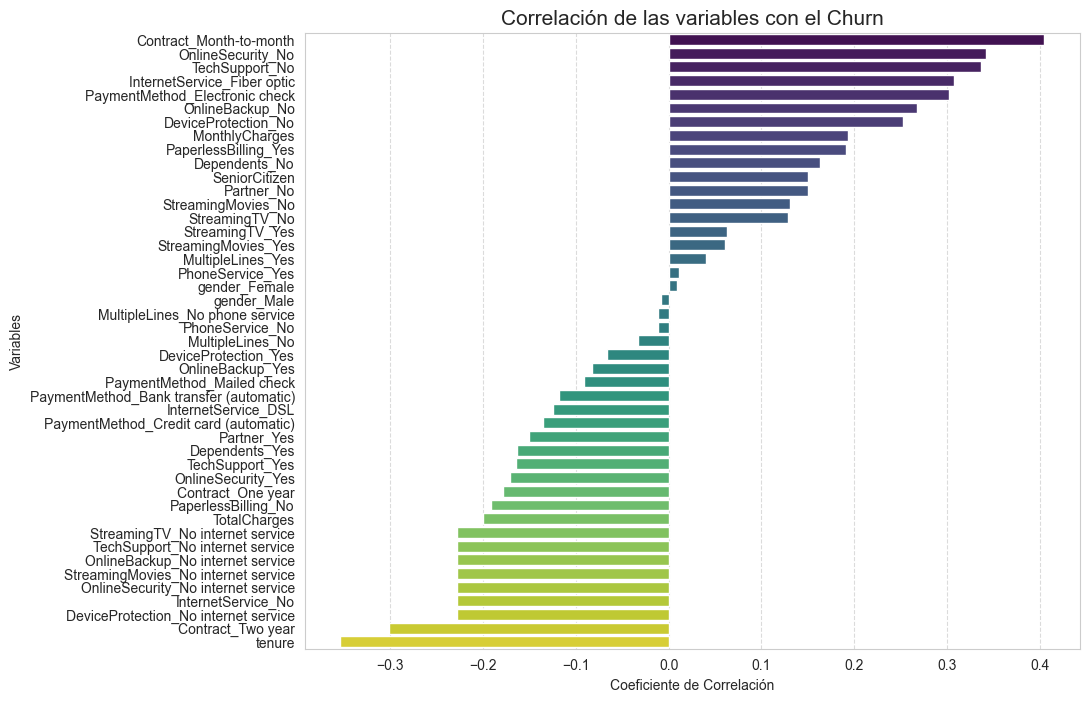

In [22]:
df = df.drop([ 'customerID'], axis=1)
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})
cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 
        'InternetService', 'OnlineSecurity','Contract' ,'OnlineBackup', 'DeviceProtection', 
        'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaymentMethod', 'PaperlessBilling']

df_encoded = pd.get_dummies(
    df, 
    columns=cols,  # Sin los corchetes adicionales []
    drop_first=False
).astype(int)


correlations = df_encoded.corr()['Churn'].sort_values(ascending=False)


correlations = correlations.drop('Churn')

plt.figure(figsize=(10, 8))
sns.barplot(x=correlations.values, y=correlations.index, palette='viridis')

plt.title('Correlación de las variables con el Churn', fontsize=15)
plt.xlabel('Coeficiente de Correlación')
plt.ylabel('Variables')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

In [23]:
corr_matrix = df_encoded.corr()['Churn'].abs().sort_values(ascending=False)

umbral = 0.05

variables_basura = correlations[correlations.abs() < umbral].index.tolist()

print(f"Variables identificadas como basura: {variables_basura}")

Variables identificadas como basura: ['MultipleLines_Yes', 'PhoneService_Yes', 'gender_Female', 'gender_Male', 'MultipleLines_No phone service', 'PhoneService_No', 'MultipleLines_No']


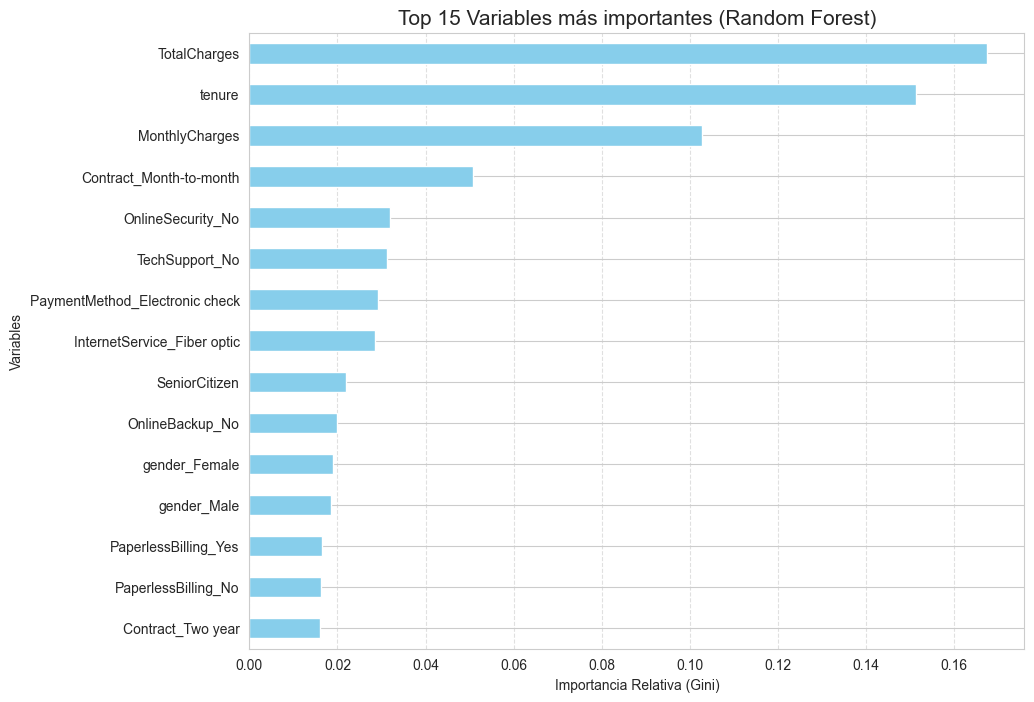

In [24]:
X = df_encoded.drop(['Churn'], axis=1, errors='ignore')
if 'customerID' in X.columns:
    X = X.drop('customerID', axis=1)

y = df_encoded['Churn']

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X, y)

# 3. Extraemos las importancias y las organizamos
importancias = pd.Series(rf_model.feature_importances_, index=X.columns)
importancias_ordenadas = importancias.sort_values(ascending=True) # Ascendente para el gráfico horizontal


plt.figure(figsize=(10, 8))
importancias_ordenadas.tail(15).plot(kind='barh', color='skyblue')
plt.title('Top 15 Variables más importantes (Random Forest)', fontsize=15)
plt.xlabel('Importancia Relativa (Gini)')
plt.ylabel('Variables')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

In [25]:
umbral_gini = 0.01 
variables_basura_rf = importancias[importancias < umbral_gini].index.tolist()
print(f"Variables que aportan menos del {umbral_gini*100}%:")
print(variables_basura_rf)

Variables que aportan menos del 1.0%:
['PhoneService_No', 'PhoneService_Yes', 'MultipleLines_No phone service', 'InternetService_No', 'OnlineSecurity_No internet service', 'OnlineBackup_No internet service', 'DeviceProtection_No internet service', 'TechSupport_No internet service', 'StreamingTV_No internet service', 'StreamingMovies_No internet service']


In [26]:
cols=   ['PhoneService_No', 'PhoneService_Yes', 'MultipleLines_No phone service', 'InternetService_No', 'OnlineSecurity_No internet service', 'OnlineBackup_No internet service', 'DeviceProtection_No internet service', 'TechSupport_No internet service', 'StreamingTV_No internet service', 
        'StreamingMovies_No internet service','MultipleLines_Yes', 'PhoneService_No', 'MultipleLines_No']
df_limpio=df_encoded.drop(columns=cols,axis=1)

In [27]:
### Dataset a Utilizar en el modelo es el df_limpio

df_limpio.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,...,StreamingTV_No,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,PaperlessBilling_No,PaperlessBilling_Yes
0,0,1,29,29,0,1,0,0,1,1,...,1,0,1,0,0,0,1,0,0,1
1,0,34,56,1889,0,0,1,1,0,1,...,1,0,1,0,0,0,0,1,1,0
2,0,2,53,108,1,0,1,1,0,1,...,1,0,1,0,0,0,0,1,0,1
3,0,45,42,1840,0,0,1,1,0,1,...,1,0,1,0,1,0,0,0,1,0
4,0,2,70,151,1,1,0,1,0,1,...,1,0,1,0,0,0,1,0,0,1


### Modelado

In [30]:
from sklearn.model_selection import train_test_split

target = "Churn"

X = df_limpio.drop(columns=[target])
y = df_limpio[target]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)


In [ ]:
models = {}

### Regresión Logistica

In [ ]:
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(
    max_iter=2000,
    class_weight="balanced"
)

logit.fit(X_train, y_train)
models["Logística"] = logit


### Ridge

In [ ]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
models["Ridge"] = ridge


### Lasso

In [ ]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.001)
lasso.fit(X_train, y_train)
models["Lasso"] = lasso


### Elasticnet

In [ ]:
from sklearn.linear_model import ElasticNet

elastic = ElasticNet(
    alpha=0.001,
    l1_ratio=0.5
)

elastic.fit(X_train, y_train)
models["Elastic Net"] = elastic


### SGDClassifier

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(
    loss="log_loss",
    max_iter=2000,
    class_weight="balanced",
    random_state=42
)

sgd.fit(X_train, y_train)
models["SGD"] = sgd


### LDA

### SVM

In [ ]:
from sklearn.svm import SVC

svm = SVC(
    kernel="rbf",
    probability=True,
    class_weight="balanced"
)

svm.fit(X_train, y_train)
models["SVM"] = svm


### KNN

### Naïve Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

models["Naive Bayes"] = GaussianNB().fit(X_train, y_train)

### Árboles de Decisión

###  MLPClassifier

In [ ]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(
    hidden_layer_sizes=(50, 25),
    max_iter=2000,
    random_state=42
)

mlp.fit(X_train, y_train)
models["MLP"] = mlp


### Random Forest

### Gradient Boosting

### AdaBoost

### Evaluación train vs test

In [ ]:
from sklearn.metrics import roc_auc_score, f1_score

results = []

for name, model in models.items():

    # TRAIN
    if name in ["Ridge", "Lasso", "Elastic Net"]:
        y_score_train = model.predict(X_train)
        y_pred_train = (y_score_train >= 0.5).astype(int)
        y_proba_train = y_score_train
    else:
        y_pred_train = model.predict(X_train)
        y_proba_train = model.predict_proba(X_train)[:, 1]

    roc_train = roc_auc_score(y_train, y_proba_train)
    f1_train = f1_score(y_train, y_pred_train)

    # TEST
    if name in ["Ridge", "Lasso", "Elastic Net"]:
        y_score_test = model.predict(X_test)
        y_pred_test = (y_score_test >= 0.5).astype(int)
        y_proba_test = y_score_test
    else:
        y_pred_test = model.predict(X_test)
        y_proba_test = model.predict_proba(X_test)[:, 1]

    roc_test = roc_auc_score(y_test, y_proba_test)
    f1_test = f1_score(y_test, y_pred_test)

    results.append((
        name,
        roc_train, f1_train,
        roc_test, f1_test
    ))


### Tabla train vs test

In [ ]:
import pandas as pd

df_results = pd.DataFrame(
    results,
    columns=[
        "Modelo",
        "ROC_AUC_Train", "F1_Train",
        "ROC_AUC_Test", "F1_Test"
    ]
)

df_results.sort_values("ROC_AUC_Test", ascending=False)

